In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Monto Carlo for Mean Exit Time
1. Choose step size $\Delta t$
2. Choose a number of paths, M

```Python
for s = 1 to M: 
        set t_n=0 and X_n=X_0
        While X_n > a and X_n < b:
            eps_n = N(0,1)
            X_n = X_n + delta_t f(X_n) + sqrt(delta_t) * eps_n * g(X_n)
            t_n = t_n + delta_t
        T_exit = t_n - 0.5*delta_t
a_M = (1/M)* sum(T_exit)
b2_M = (1/M-1)*sum(T_exit - a_M)**2```

## Sources of error 
1. Sampling error arising from approximation of an expected value by sample mean 
2. Discritisation error
3. Risk of missing exit point within an interval $t_{i} < t < t_{i+1}$

Solutions:
1. Adaptive timesteps
2. After each step, calculate the probability that an exit was missed. Then draw from a uniform (0, 1) random number generator in order to decide whether to record an exit.
3. Use random stepsizes from a suitable exponential distribution.

In [17]:
class AdaptiveTimestep:
    """
    The class that contains methods for adaptive timesteps
    """
    def __init__(self):
        pass
    
    # TODO: Need tp update number of iterations accordingly
    # TODO: Stop process when hit the boundaries
    # Tanh is not appropriate for process which changes are very small and initial value is close to the boundareis
    # TODO: choice of distance function must be based on the stochastic process (how fast they change along y-axis in 1D)
    # The adaption can be calibrated by sampling from process to examine rate of change (learn the apdation)
    # Use Interative method to find the exact hitting time after crossing a boundary rather than taking average
    # TODO: Store value of timesteps and add visualisation of how timesteps chenage according to the value of function
    def naive_adaption(self, LB, UB, dt, x):
        """
        A naive method to adapt timestep based on the distance to the boundaries
        """
        epsilon = 1e-10
        dist = min(abs(x - LB), abs(x - UB))
        dt_new = (abs(np.tanh(dist))+epsilon) * dt
        return dt_new
    
    def kev_method1(self, LB, UB, x, f, g, dt):
        y = np.sqrt(dt)
        kev_coeff = 1.96 # set to 1.96 for 95% credible interval of gaussian distribution
        min_dt = 0.000001

        cond1 = (LB-x)/f(x) + (kev_coeff*g(x)/(2*f(x)))**2
        cond2 = (UB-x)/f(x) + (kev_coeff*g(x)/(2*f(x)))**2
        
        if cond1 < 0 and cond2 < 0:
            print('Current values:')
            print('Cond1:', cond1)
            print('Cond2:', cond2)
            print('X:', x)
            assert('No Condition is satisfied')
            
        elif cond1 < 0:
            y = min(np.sqrt(cond2) + kev_coeff*g(x)/(2*f(x)), np.sqrt(cond2) - kev_coeff*g(x)/(2*f(x)))
        elif cond2 < 0:
            y = min(-np.sqrt(cond1) + kev_coeff*g(x)/(2*f(x)), -np.sqrt(cond1) - kev_coeff*g(x)/(2*f(x)))
        else:
            y = min(np.sqrt(cond2) + kev_coeff*g(x)/(2*f(x)), np.sqrt(cond2) - kev_coeff*g(x)/(2*f(x)),-np.sqrt(cond1) + kev_coeff*g(x)/(2*f(x)), -np.sqrt(cond1) - kev_coeff*g(x)/(2*f(x)) )
        
        return min(dt, max(y**2,min_dt ))
    
    def kev_method2(self, LB, UB, x, f, g, dt):
        min_dt = 0.0000001
        k = 3 # set to 1.96 for 95% credible interval of gaussian distribution
        
        if f(x) == 0 and g(x) == 0:
            return dt
        elif g(x) == 0:
            dt_new = min((UB-x)/f(x), (x-LB)/f(x))
            return min(dt, max(dt_new, min_dt))
        elif f(x) == 0:
            if g(x) > 0:
                dt_new = ((UB-x)/(k*g(x)))**2
                return min(dt, max(dt_new, min_dt))
            else:
                dt_new = ((x-LB)/(k*g(x)))**2
                return min(dt, max(dt_new, min_dt))
        elif f(x) > 0:
            t1 = np.sqrt( ((UB-x)/f(x)) + ((k*g(x))/(2*f(x)))**2) - (k*g(x))/(2*f(x))
            t2 = np.sqrt( ((UB-x)/f(x)) + ((k*g(x))/(2*f(x)))**2) + (k*g(x))/(2*f(x))
            dt_new = min(t1**2, t2**2)
            return min(dt, max(dt_new, min_dt))
        
        t1 = np.sqrt( ((x-LB)/f(x)) + ((k*g(x))/(2*f(x)))**2) - (k*g(x))/(2*f(x))
        t2 = np.sqrt( ((x-LB)/f(x)) + ((k*g(x))/(2*f(x)))**2) + (k*g(x))/(2*f(x))
        dt_new = min(t1**2, t2**2)
        return min(dt, max(dt_new, min_dt))
    
    
    

## Mean exit time for deterministic ODE ($dX_{t} = f(X_{t})dt + g(X(t))dW(t), X(0) = X_{0}$)
$u(x)$ denotes $T_{exit}^{mean}$
$$\frac{1}{2}g^2(x)\frac{d^{2}u}{dx^{2}} + f(x)\frac{du}{dx}=-1$$
$$u(a) = u(b) = b$$

## Example (Asset Prices) ($f(x) = \mu X, g(x) = \sigma X$)
$$X_{t} = \mu X dt + \sigma X dW \qquad 0 < a < X_{0} < b$$
We are interested in expected value of the first time that the asset either dips below the lower bound a or rises above the upper bound b.
The analystical solution for mean exit time can e computed by  solving the following ODE:
$$\frac{1}{2}\sigma^{2}x^{2}\frac{d^{2}x}{dx^{2}} + \mu x \frac{du}{dx} = -1 \qquad a < x< b and u(a) = u(b) = 0$$
$$u(x) = \frac{1}{\frac{1}{2}\sigma^{2}-\mu} \left( log(\frac{x}{a})- \frac{1 - (x/a)^{1-2 \mu/\sigma^{2}}}{1 - (b/a)^{1-2\mu / \sigma^{2}}}log(b/a)\right) $$

In [18]:
import random
class AssetPrice:
    """
    This is a class for Asset Price ODE. 
    It contains methods for finding exact solution, plotting and exat mean hitting time.
    Arguments:
    a: Lower bound
    b: Upper bound
    mu: mu
    sigma: sigma
    """
    def __init__(self, a, b, mu, sigma):
        self.a = a
        self.b = b
        self.mu = mu
        self.sigma = sigma
        
    def f(self,x):
        """
        Function of f(x) in asset price stochastic differential equation (deterministic part)
        """
        return self.mu * x
    
    def g(self,x):
        """
        Function of g(x) in asset price stochastic differential equation (stochastic part)
        """
        return self.sigma * x
  
    def MHT_Xt_exact(self,X0,dt,npaths, adaptive= False):
        """
        Methods that return mean hitting time of X(t)
        
        Arguments:
        X0: Initial value
        dt: timestep
        
        Return: List containing Mean, STD, Confidence interval Left, Confidence interval Right
        """
        
        sigma = self.sigma; mu = self.mu
        exit_time = np.zeros(npaths)
        # TODO: Add threshold for situation when the loop goes forever
        for i in tqdm(range(npaths)):
            X = X0
            t = 0
            while X > self.a and X < self.b:
                dW = np.sqrt(dt) * np.random.randn()
                X = X*np.exp( (mu - 0.5*(sigma**2))*dt + sigma*dW)
                t = t + dt
            
            exit_time[i] = t - 0.5*dt
            
        tmean = np.mean(exit_time)
        tstd = np.std(exit_time)

        cileft = tmean - 1.96*tstd/np.sqrt(npaths)
        ciright = tmean + 1.96*tstd/np.sqrt(npaths)
        
        return tmean, tstd, cileft, ciright
    
    def MHT_EM(self,X0,dt,npaths, adaptive= False):
        """
        Method that approxiamte a solution using Euler-Maruyama method
        
        Arguments:
        f: F(x)
        g: g(x)
        
        Return: List containing Mean, STD, Confidence interval Left, Confidence interval Right
        """
        sigma = self.sigma; mu = self.mu
        # TODO: Add threshold for situation when the loop goes forever
        exit_time = np.zeros(npaths)
        
        if adaptive:
            AdaptiveT = AdaptiveTimestep()
            for i in tqdm(range(npaths)):
                X = X0
                t = 0
                while X > self.a and X < self.b:
                    dt_new_EM = AdaptiveT.kev_method2(LB=self.a, UB=self.b, x=X, f=self.f, g=self.g, dt=dt)
                    dW = np.sqrt(dt_new_EM)*np.random.randn()
                    X = X + dt_new_EM*self.f(X) + self.g(X)*dW
                    t += dt_new_EM
#                     print(X, ', ',dt_new_EM,', ', t)
                
#                 print('Time: ',t)
                exit_time[i] = t
            
        else:
            for i in tqdm(range(npaths)):
                X = X0
                t = 0
                while X > self.a and X < self.b:
                    dW = np.sqrt(dt) * np.random.randn()
                    X = X + dt*self.f(X) + self.g(X)*dW
                    t += dt

                exit_time[i] = t - 0.5*dt
            
        
            
        tmean = np.mean(exit_time)
        tstd = np.std(exit_time)

        cileft = tmean - 1.96*tstd/np.sqrt(npaths)
        ciright = tmean + 1.96*tstd/np.sqrt(npaths)
        
        return tmean, tstd, cileft, ciright
    
    def MHT_Milstein(self,X0,dt,npaths, adaptive= False):
        """
        Method that approxiamte a solution using Euler-Maruyama method
        
        Arguments:
        f: F(x)
        g: g(x)
        
        Return: List containing Mean, STD, Confidence interval Left, Confidence interval Right
        """
        sigma = self.sigma; mu = self.mu
        # TODO: Add threshold for situation when the loop goes forever
        exit_time = np.zeros(npaths)
        for i in tqdm(range(npaths)):
            X = X0
            t = 0
            while X > self.a and X < self.b:
                dW = np.sqrt(dt) * np.random.randn()
                X = X + dt*self.f(X) + self.g(X)*dW + 0.5 * self.g(X)*sigma*(dW**2 - dt)
                t += dt
            
            exit_time[i] = t - 0.5*dt
            
        tmean = np.mean(exit_time)
        tstd = np.std(exit_time)

        cileft = tmean - 1.96*tstd/np.sqrt(npaths)
        ciright = tmean + 1.96*tstd/np.sqrt(npaths)
        
        return tmean, tstd, cileft, ciright
    
    
    
    def Ux(self,x):
        """
        Method to return exact mean hitting time
        
        Arguments:
        x: Path values (array)
        
        Return: Array containing exact mean hitting time for given initial values
        
        """
        c1 = 1/(0.5*(self.sigma**2) - self.mu)
        c2 = 1 - (x/self.a)**(1-2*self.mu/(self.sigma**2))
        c3 = 1 - (self.b/self.a)**(1-2*self.mu/(self.sigma**2))
        ux = c1*(np.log(x/self.a) - (c2/c3)*np.log(self.b/self.a))
        return ux
    
    

    def Asset_Price_Exact(self, a, b, mu, sigma, adaptive=False ):
        """
        Method to compute the hitting times for M interations for Asset Price
        
        Arguments
        a: Lower bound
        b: Upper bound
        mu: mu
        sigma: sigma
        
        Return: Numpy array of hitting time for each iteration
        """
        AP = AssetPrice(a=a, b=b, mu=mu, sigma=sigma)
        AP_samples = np.zeros(self.M)
        for t in tqdm(range(self.niter)):
            AP_exact_sol = AP.Xt_exact(X0 = self.X0, duration = self.duration, dt = self.dt, adaptive=adaptive)
            hit_time = np.where((AP_exact_sol <= a) | (AP_exact_sol >= b))[0]
            hit_time = np.append(hit_time, int(1e10)) # Inf i.e never hit 
            AP_samples[t] = hit_time[0]*self.dt - 0.5*self.dt
        return AP_samples
    
    def Xt_path(self,X0,duration,dt):
        """
        Methods that return paths of X(t)
        
        Arguments:
        X0: Initial value
        duration: The duration for running process
        dt: timestep
        
        Return: Array of a path
        """
        
        X_exact = [] + [X0]
        X_EM = [] + [X0]
        X_Mils = [] + [X0]
        
        
        tsteps_EM_AT = []
        X_EM_AT = [] + [X0]
        
         
        timestamps1 = [] + [0]
        timestamps2 = [] + [0]
        AdaptiveT = AdaptiveTimestep()
        
        time_elapsed = 0
        while time_elapsed < duration:
            dW = np.sqrt(dt)*np.random.randn() # increments
           
            X_exact = X_exact + [X_exact[-1]*np.exp((self.mu - 0.5*self.sigma**2)*dt + self.sigma*dW)]
            X_EM = X_EM + [X_EM[-1] + dt*self.f(X_EM[-1]) + self.g(X_EM[-1])*dW]
            X_Mils = X_Mils + [X_Mils[-1] + dt*self.f(X_Mils[-1]) + self.g(X_Mils[-1])*dW + 0.5 * self.g(X_Mils[-1])*self.sigma*(dW**2 - dt)]
            time_elapsed += dt
            timestamps1 = timestamps1 + [time_elapsed]
         
        time_elapsed = 0
        while time_elapsed < duration:
            dt_new_EM = AdaptiveT.kev_method2(LB=self.a, UB=self.b, x=X_EM_AT[-1], f=self.f, g=self.g, dt=dt)
            dW = np.sqrt(dt_new_EM)*np.random.randn()
            X_EM_AT = X_EM_AT + [X_EM_AT[-1] + dt_new_EM*self.f(X_EM_AT[-1]) + self.g(X_EM_AT[-1])*dW]
            tsteps_EM_AT = tsteps_EM_AT + [dt_new_EM]
            time_elapsed += dt_new_EM
            timestamps2 = timestamps2 + [time_elapsed]
                    
                
        return X_exact, X_EM, X_Mils, X_EM_AT, timestamps1, timestamps2

    def _plot(self,X0,duration,dt):
        """
        Method to plot a path
        
        Arguments:
        X0: intial value
        duration: The duration for running process
        dt: timestep
        """
        t = np.arange(0,duration,dt)

        xt_exact, xt_EM, xt_Milstein, xt_EM_A, timestamps1, timestamps2 = self.Xt_path(X0,duration,dt)
     
        plt.figure(figsize=(20,10))
#         plt.plot(timestamps1, xt_exact, color='green', label='Exact')
        plt.plot(timestamps1, xt_EM, color='purple', label='EM')
#         plt.plot(timestamps1, xt_Milstein, color='orange', label='Milstein')
        plt.plot(timestamps2, xt_EM_A,linestyle='dashed',color='purple', label='EM')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.hlines(self.b, xmin=0, xmax=max(timestamps1), color='red', label='$b$')
        plt.hlines(self.a,xmin=0, xmax=max(timestamps1), color='blue', label='$a$')
        plt.title('Stock Price SDE')
        plt.legend()

In [19]:
random.seed(100)
print(np.random.randn())
print(np.random.randn())

-1.3617002374788139
0.18538333272252341


In [20]:
AssetPrice1 = AssetPrice(a=0.5, b=2, mu=0.1, sigma=0.2)

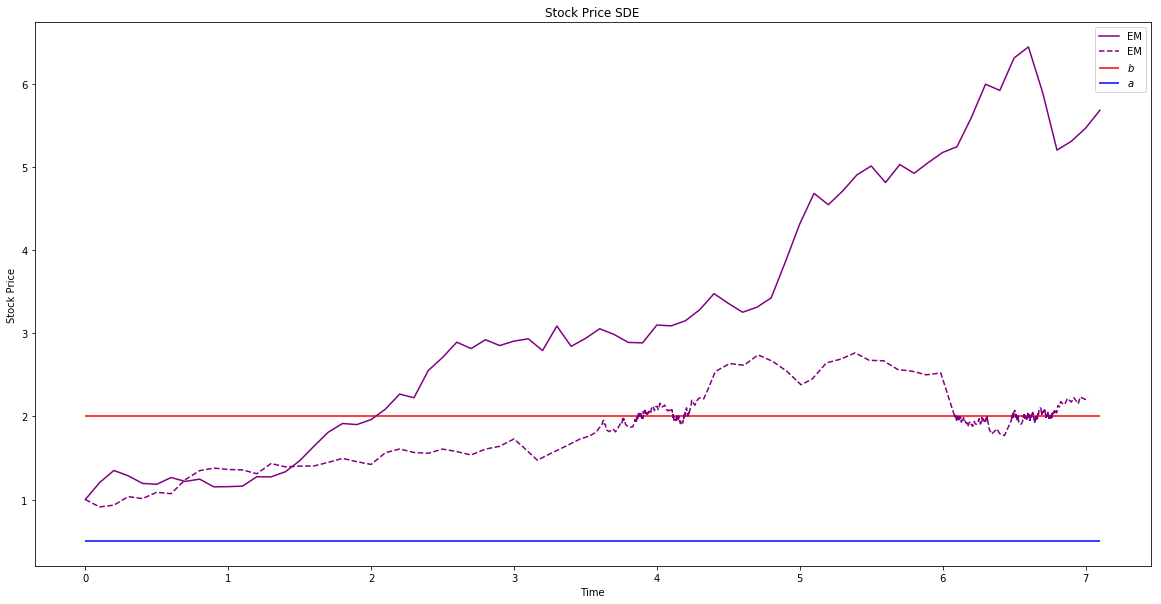

In [21]:
AssetPrice1._plot(X0 = 1,duration = 7, dt = 0.1)

In [7]:
xVals = np.linspace(AssetPrice1.a, AssetPrice1.b, 1000)
uVals = AssetPrice1.Ux(xVals)

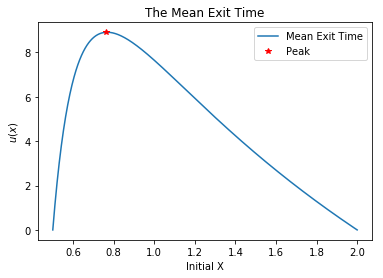

In [8]:
plt.plot(xVals, uVals, label='Mean Exit Time')
plt.plot(0.76, AssetPrice1.Ux(0.76),'*', color='red', label='Peak')
plt.xlabel('Initial X')
plt.ylabel('$u(x)$')
plt.title('The Mean Exit Time')
plt.legend()

In [25]:
AP1 = AssetPrice(a=0.5, b=2, mu=0.1, sigma=0.2)
npaths = 50000
dt= 0.1

In [26]:
tmean_exact, tstd_exact, cileft_exact, ciright_exact = AP1.MHT_Xt_exact(X0=1,dt=dt,npaths=npaths, adaptive= False)

100%|██████████| 50000/50000 [00:03<00:00, 13161.91it/s]


In [27]:
tmean_EM, tstd_EM, cileft_EM, ciright_EM = AP1.MHT_EM(X0=1,dt=dt,npaths=npaths, adaptive= False)

100%|██████████| 50000/50000 [00:02<00:00, 19516.88it/s]


In [28]:
tmean_Milstein, tstd_Milstein, cileft_Milstein, ciright_Milstein = AP1.MHT_Milstein(X0=1,dt=dt,npaths=npaths, adaptive= False)

100%|██████████| 50000/50000 [00:03<00:00, 13672.70it/s]


In [29]:
tmean_EM_AT, tstd_EM_AT, cileft_EM_AT, ciright_EM_AT = AP1.MHT_EM(X0=1,dt=dt,npaths=npaths, adaptive= True)

100%|██████████| 50000/50000 [02:07<00:00, 392.07it/s]


In [30]:
print('Mean Hitting Time for dt:{} and number of paths: {}'.format(dt, npaths))
print('\n')

print('----- Exact Solution -----')
print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(tmean_exact))
print('Estimated Exit Mean std: {}'.format(tstd_exact))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_exact,r=ciright_exact))
print('\n')


print('----- Euler Maryama Estimation -----')
print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(tmean_EM))
print('Estimated Exit Mean std: {}'.format(tstd_EM))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_EM,r=ciright_EM))
print('\n')


print('----- Milstein Approximation -----')
print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(tmean_Milstein))
print('Estimated Exit Mean std: {}'.format(tstd_Milstein))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_Milstein,r=ciright_Milstein))
print('\n')


print('----- Euler Maryama with Adaptive Timestep Estimation -----')
print('Estimated Exit Time - with Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(tmean_EM_AT))
print('Estimated Exit Mean std: {}'.format(tstd_EM_AT))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_EM_AT,r=ciright_EM_AT))
print('\n')

print('Exact Mean Hitting Time: {}'.format(7.6450))

Mean Hitting Time for dt:1 and number of paths: 50000


----- Exact Solution -----
Estimated Exit Time - Without Adaptive Timestep
Estimated Exit Mean: 9.13326
Estimated Exit Mean std: 6.6586876914599324
Estimated Exit Mean Confidence Interval: (9.074894028989341,9.191625971010659)


----- Euler Maryama Estimation -----
Estimated Exit Time - Without Adaptive Timestep
Estimated Exit Mean: 9.01858
Estimated Exit Mean std: 6.316446373048694
Estimated Exit Mean Confidence Interval: (8.963213906411834,9.073946093588166)


----- Milstein Approximation -----
Estimated Exit Time - Without Adaptive Timestep
Estimated Exit Mean: 9.46622
Estimated Exit Mean std: 6.541452354913242
Estimated Exit Mean Confidence Interval: (9.408881642022324,9.523558357977675)


----- Euler Maryama with Adaptive Timestep Estimation -----
Estimated Exit Time - with Adaptive Timestep
Estimated Exit Mean: 8.052745887055124
Estimated Exit Mean std: 5.842586987049825
Estimated Exit Mean Confidence Interval: (8.0015333541

In [ ]:
npaths = 50000
dt= 1

In [ ]:
MHT_exact2 = AP1.MHT_Xt_exact(X0=1,dt=dt,npaths=npaths, adaptive= False)

In [ ]:
MHT_EM2 = AP1.MHT_EM(X0=1,dt=dt,npaths=npaths, adaptive= False)

In [ ]:
MHT_Mils2 = AP1.MHT_Milstein(X0=1,dt=dt,npaths=npaths, adaptive= False)

In [ ]:

print('Mean Hitting Time for dt:{} and number of paths: {}'.format(dt, npaths))

exit_mean_exact = np.mean(MHT_exact2)
exit_std_exact = np.std(MHT_exact2)
cileft_exact = exit_mean_exact - 1.96*exit_std_exact/np.sqrt(npaths)
ciright_exact = exit_mean_exact + 1.96*exit_std_exact/np.sqrt(npaths)

print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(exit_mean_exact))
print('Estimated Exit Mean std: {}'.format(exit_std_exact))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_exact,r=ciright_exact))
print('\n')


exit_mean_EM = np.mean(MHT_EM2)
exit_std_EM = np.std(MHT_EM2)
cileft_EM = exit_mean_exact - 1.96*exit_std_EM/np.sqrt(npaths)
ciright_EM = exit_mean_exact + 1.96*exit_std_EM/np.sqrt(npaths)

print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(exit_mean_EM))
print('Estimated Exit Mean std: {}'.format(exit_std_EM))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_EM,r=ciright_EM))
print('\n')


exit_mean_Mils = np.mean(MHT_Mils2)
exit_std_Mils = np.std(MHT_Mils2)
cileft_Mils = exit_mean_exact - 1.96*exit_std_Mils/np.sqrt(npaths)
ciright_Mils = exit_mean_exact + 1.96*exit_std_Mils/np.sqrt(npaths)

print('Estimated Exit Time - Without Adaptive Timestep')
print('Estimated Exit Mean: {}'.format(exit_mean_Mils))
print('Estimated Exit Mean std: {}'.format(exit_std_Mils))
print('Estimated Exit Mean Confidence Interval: ({l},{r})'.format(l=cileft_Mils,r=ciright_Mils))
print('\n')

print('Exact Mean Hitting Time: {}'.format(7.6450))

In [ ]:
plt.figure(figsize=(12,6))
(n, bins, patches) = plt.hist(AP1, bins=100, label='hst',)
plt.vlines(exit_mean1, ymin = 0, ymax =4000, label='Estimated Mean', color='red')
plt.vlines(7.6450, ymin = 0, ymax =4000, label='Exact Mean', color='blue')
plt.vlines(cileft1, ymin = 0, ymax =4000, label='0.025 Confidence Interval', color='purple')
plt.vlines(ciright1, ymin = 0, ymax =4000, label='0.975 Confidence Interval', color='purple')
plt.title('Histogram of mean exit times for $M = 5 × 10^5$ sample paths - Without Adaptive Timestep')
plt.xlabel('First Exit Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
(n, bins, patches) = plt.hist(AP2, bins=100, label='hst',)
plt.vlines(exit_mean2, ymin = 0, ymax =4000, label='Estimated Mean', color='red')
plt.vlines(7.6450, ymin = 0, ymax =4000, label='Exact Mean', color='blue')
plt.vlines(cileft2, ymin = 0, ymax =4000, label='0.025 Confidence Interval', color='purple')
plt.vlines(ciright2, ymin = 0, ymax =4000, label='0.975 Confidence Interval', color='purple')
plt.title('Histogram of mean exit times for $M = 5 × 10^5$ sample paths - With Adaptive Timestep')
plt.xlabel('First Exit Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# class MontoCarlo:
#     """
#     This is a class that contain Monto Carlo methods
#     Arguments:
#     X0: Intial value
#     M: Number of iteration
#     dt: Timestep
#     duration: The duration for running a process
#     """
#     def __init__(self, X0, M, dt, duration):
#         self.X0 = X0
#         self.M = M
#         self.dt = dt 
#         self.duration = duration
#         self.n = int(duration / dt)
#         self.Xn = np.zeros(self.n); self.Xn[0] = X0
#         self.W = np.random.normal(0,1, self.n)
    

#     def Euler_Maruyama(self, f, g):
#         """
#         Method that approxiamte a solution using Euler-Maruyama method
        
#         Arguments:
#         f: F(x)
#         g: g(x)
        
#         Return: Array containing path
#         """
#         for i in range(1, self.n-1):
#             self.Xn[i] = self.Xn[i-1] + self.dt*f(Xn[i-1]) + g(x[i-1])*(self.W[i] - self.W[i-1])
#         return self.Xn
    

#     def Asset_Price_Exact(self, a, b, mu, sigma, adaptive=False):
#         """
#         Method to compute the hitting times for M interations for Asset Price
        
#         Arguments
#         a: Lower bound
#         b: Upper bound
#         mu: mu
#         sigma: sigma
        
#         Return: Numpy array of hitting time for each iteration
#         """
#         AP = AssetPrice(a=a, b=b, mu=mu, sigma=sigma)
#         AP_samples = np.zeros(self.M)
#         for t in tqdm(range(self.M)):
#             AP_exact_sol = AP.Xt_exact(X0 = self.X0, duration = self.duration, dt = self.dt, adaptive=adaptive)
#             hit_time = np.where((AP_exact_sol <= a) | (AP_exact_sol >= b))[0]
#             hit_time = np.append(hit_time, int(1e10)) # Inf i.e never hit 
#             AP_samples[t] = hit_time[0]*self.dt - 0.5*self.dt
#         return AP_samples
        

In [ ]:
# class AssetPrice:
#     """
#     This is a class for Asset Price ODE. 
#     It contains methods for finding exact solution, plotting and exat mean hitting time.
#     Arguments:
#     a: Lower bound
#     b: Upper bound
#     mu: mu
#     sigma: sigma
#     """
#     def __init__(self, a, b, mu, sigma, dt, X0, niter):
#         self.a = a
#         self.b = b
#         self.mu = mu
#         self.sigma = sigma
#         self.Xt = None
#         self.dt = dt
#         self.X0 = X0
#         self.niter = niter
        
#     def f(self,x):
#         """
#         Function of f(x) in asset price stochastic differential equation (deterministic part)
#         """
#         return self.mu * x
    
#     def g(self,x):
#         """
#         Function of g(x) in asset price stochastic differential equation (stochastic part)
#         """
#         return self.sigma * x
  
#     def Xt_exact(self,X0,duration,dt, adaptive= False):
#         """
#         Methods that return paths of X(t)
        
#         Arguments:
#         X0: Initial value
#         duration: The duration for running process
#         dt: timestep
        
#         Return: Array of a path
#         """
#         t = np.arange(0,duration,dt)
#         n = int(duration/dt)
#         X = np.zeros(n)
#         X[0] = X0
        
#         if adaptive:
#             AdaptiveT =  AdaptiveTimestep()
#             for i in range(1,n):
#                 dW = np.sqrt(dt)*np.random.randn() # increments
#                 dt_new = AdaptiveT.naive_adaption(LB=self.a, UB=self.b, dt = dt, curr_val=X[i-1])
#                 X[i] = X[i-1]*np.exp((self.mu - 0.5*self.sigma**2)*dt_new + self.sigma*dW);
            
#         else:
#             for i in range(1,n):
#                 dW = np.sqrt(dt)*np.random.randn() # increments
#                 X[i] = X[i-1]*np.exp((self.mu - 0.5*self.sigma**2)*dt + self.sigma*dW);
                
#         return X
    
#     def _plot(self,X0,duration,dt, exact = True):
#         """
#         Method to plot a path
        
#         Arguments:
#         X0: intial value
#         duration: The duration for running process
#         dt: timestep
#         """
#         t = np.arange(0,duration,dt)
#         title = ''
#         if exact:
#             xt = self.Xt_exact(X0,duration,dt)
#             title = 'Exact Solution'
#         else:
#             xt = self.EM(X0,duration,dt)
#             title = 'EM Estimated Solution'
            
        
        
#         plt.figure(figsize=(20,10))
#         plt.plot(t, xt)
#         plt.xlabel('Time')
#         plt.ylabel('Stock Price')
#         plt.hlines(self.b, xmin=0, xmax=max(t), color='red', label='$b$')
#         plt.hlines(self.a,xmin=0, xmax=max(t), color='blue', label='$a$')
#         plt.title('Stock Price SDE {}'.format(title))
#         plt.legend()
    
#     def Ux(self,x):
#         """
#         Method to return exact mean hitting time
        
#         Arguments:
#         x: Path values (array)
        
#         Return: Array containing exact mean hitting time for given initial values
        
#         """
#         c1 = 1/(0.5*self.sigma**2 - self.mu)
#         c2 = 1 - (x/self.a)**(1-2*self.mu/self.sigma**2)
#         c3 = 1 - (self.b/self.a)**(1-2*self.mu/self.sigma**2)
#         ux = (1/c1)*(np.log(x/self.a) - (c2/c3)*np.log(self.b/self.a))
#         return ux
    
    
#       def EM(self,X0,duration,dt, adaptive= False):
#         """
#         Method that approxiamte a solution using Euler-Maruyama method
        
#         Arguments:
#         f: F(x)
#         g: g(x)
        
#         Return: Array containing path
#         """
#         for i in range(1, self.n):
#             self.Xn[i] = self.Xn[i-1] + self.dt*self.f(Xn[i-1]) + self.g(x[i-1])*(self.W[i] - self.W[i-1])
#         return self.Xn
    

#     def Asset_Price_Exact(self, a, b, mu, sigma, adaptive=False ):
#         """
#         Method to compute the hitting times for M interations for Asset Price
        
#         Arguments
#         a: Lower bound
#         b: Upper bound
#         mu: mu
#         sigma: sigma
        
#         Return: Numpy array of hitting time for each iteration
#         """
#         AP = AssetPrice(a=a, b=b, mu=mu, sigma=sigma)
#         AP_samples = np.zeros(self.M)
#         for t in tqdm(range(self.niter)):
#             AP_exact_sol = AP.Xt_exact(X0 = self.X0, duration = self.duration, dt = self.dt, adaptive=adaptive)
#             hit_time = np.where((AP_exact_sol <= a) | (AP_exact_sol >= b))[0]
#             hit_time = np.append(hit_time, int(1e10)) # Inf i.e never hit 
#             AP_samples[t] = hit_time[0]*self.dt - 0.5*self.dt
#         return AP_samples